# Title - Fitbit Time Series Project

# Goal
1.


Notes for intial data peeking:
1. Missing data 6/27/2018 - 7/6/2018
2. Most of the records are missing Food/ Food log information.  
> Available: May - June 1 record, October - November 7 records
3. Overall data range 4/26/2018 - 12/6/2018

Index - 
April, May, June, Aug, Sept, Oct, Nov: 36-67
July: 36-66
Dec: 36-45

Hypothesis
1. Missing value can be predicted with by similar days of the weeks (weekday/ weekend
2. Missing value can be affected by month/ season of the year
3. Explore: hypothesis testing, df.corr on 
'cal_burn', 'steps', 'distance', 'floors', 'min_sed'
'min_sed','min_active_light', 'min_active_fairly', 'min_active_very','cal_activity'
'cal_burn', 'cal_activity'


# Deliverables

1. Notebook: 
> material & methods, include data preparation, summary/ data dictionary
>
> 
>
> analyses
>
> conclusions
>
> predictions: 
>
> missing two weeks worth of data (csv file)
> 
> include comment about the individual who was wearing this fitness tracker

2. Prediction result: missing two weeks worth of data (csv file)

3. 2 slides, audience = a general audience. 
> Include at least one visualization, clearly labeled

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
#import prepare
#import summarize
#from acquire import get_store_data
#from prepare import prep_store_data, split_store_data
# from summarize import df_summary

# Acquisition

In [2]:
df = acquire.acquire()

In [3]:
df = acquire.handle_obj_type(df)

In [4]:
df = acquire.basic_clean(df)

Total length of df is: 225
Total length of none-repeating dates is: 225


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
cal_burn             225 non-null int64
steps                225 non-null int64
distance             225 non-null float64
floors               225 non-null int64
min_sed              225 non-null int64
min_active_light     225 non-null int64
min_active_fairly    225 non-null int64
min_active_very      225 non-null int64
cal_activity         225 non-null int64
dtypes: float64(1), int64(8)
memory usage: 17.6 KB


In [6]:
df.describe().T

count         mean          std    min      25%      50%  \
cal_burn           225.0  3401.911111   632.426578  799.0  3069.00  3385.00   
steps              225.0  8536.186667  5255.746608    0.0  4714.00  7806.00   
distance           225.0     4.046800     2.506253    0.0     2.22     3.68   
floors             225.0    12.591111    25.844174    0.0     2.00     7.00   
min_sed            225.0   809.520000   243.232639   28.0   654.00   750.00   
min_active_light   225.0   188.235556    75.170001    0.0   158.00   203.00   
min_active_fairly  225.0    14.920000    15.363535    0.0     3.00    11.00   
min_active_very    225.0    33.871111    37.195986    0.0     2.00    15.00   
cal_activity       225.0  1484.546667   747.795790    0.0  1062.00  1481.00   

                       75%      max  
cal_burn            3765.0   5199.0  
steps              12380.0  25512.0  
distance               5.9     12.0  
floors                13.0    195.0  
min_sed              877.0   1440.0  
min_active_light     236.0    349.0  
min_active_fairly     21.0     78.0  
min_active_very       63.0    154.0  
cal_activity        1962.0   3596.0

In [7]:
train, test = acquire.split_date(df)

In [8]:
target_vars = train.columns.to_list()
train = train.resample('D')[target_vars].sum()

In [107]:
train['weekday'] = train.index.strftime('%a')
train['weeks_of_yr'] = train.index.strftime('%U')
train['months'] = train.index.strftime('%b')

train.head()

cal_burn  steps  distance  floors  min_sed  min_active_light  \
date                                                                       
2018-07-16      4037  10551      4.98       4      714               204   
2018-07-17      3760   8377      3.95      12      646               258   
2018-07-18      3509   7504      3.54       4      754               222   
2018-07-19      3993   9484      4.47       4     1116               243   
2018-07-20      3110   6680      3.15       3     1262               136   

            min_active_fairly  min_active_very  cal_activity weekday  \
date                                                                   
2018-07-16                 51               47          2084     Mon   
2018-07-17                  8               25          1803     Tue   
2018-07-18                 20                3          1502     Wed   
2018-07-19                 57               24          2093     Thu   
2018-07-20                 28               14          1172     Fri   

            week_of_day weeks_of_yr months  
date                                        
2018-07-16            3          28    Jul  
2018-07-17            3          28    Jul  
2018-07-18            3          28    Jul  
2018-07-19            3          28    Jul  
2018-07-20            3          28    Jul

In [ ]:
flights.groupby('weekday').delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
# flights.groupby(flights.index.weekday_name).delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
plt.xticks(rotation=0)

**Takeaway**
- cal_burn: slightly more calaries burned in later part of the week
- steps & distance: similar tred, definitely more, begining from thursday
- floors: very similar throughout the week, spikes up on Sunday
- min_sed: begin to drop from Friday
- similar activity level (light, very and cal_activity)
- min_active_fairly: except for Monday, activity level rise thru the week

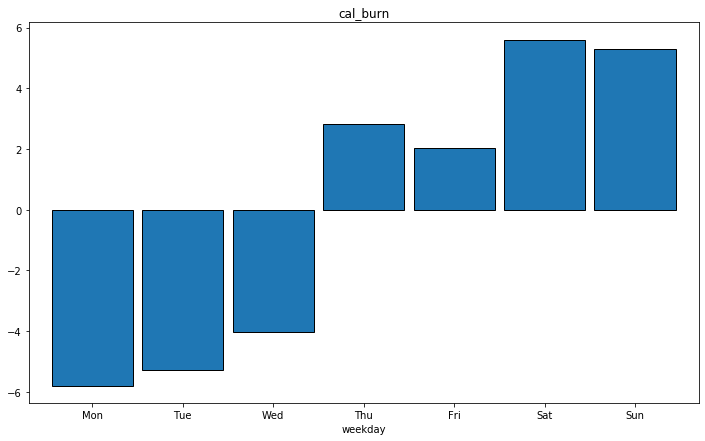

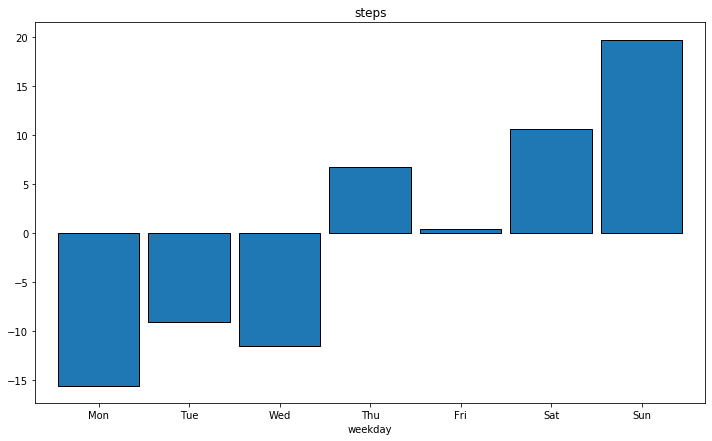

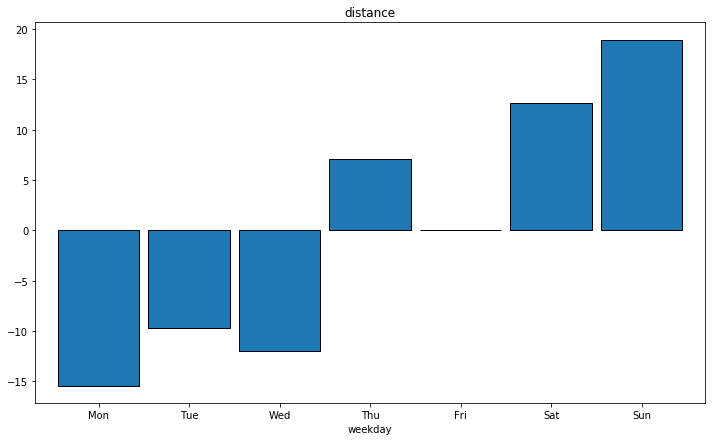

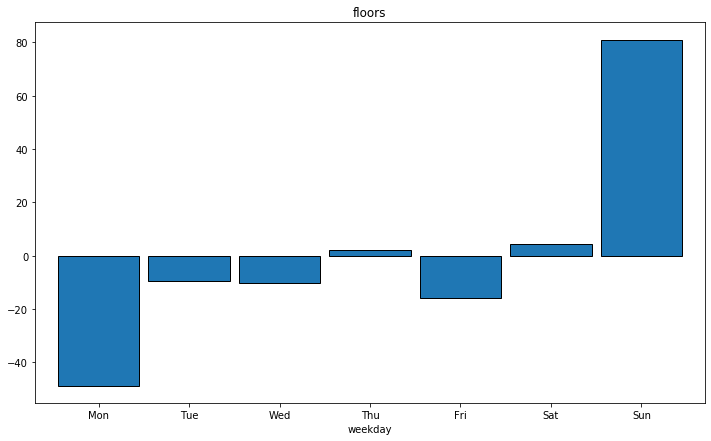

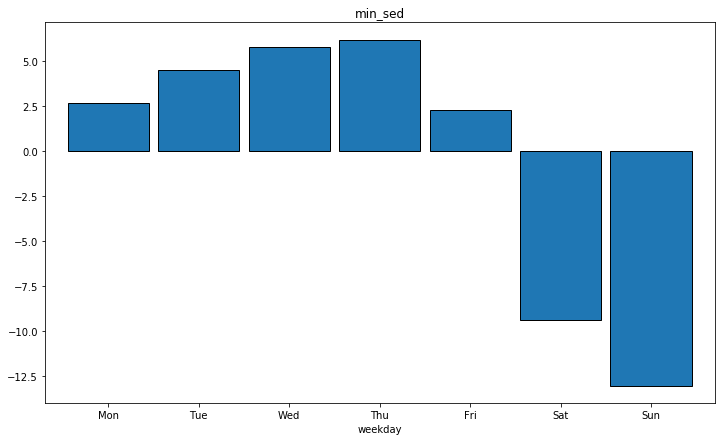

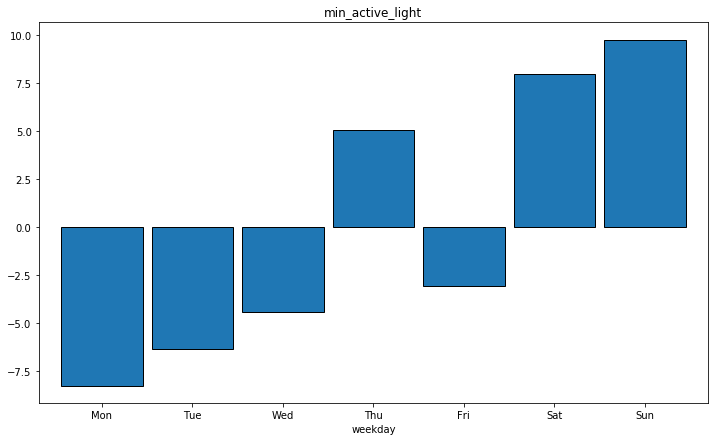

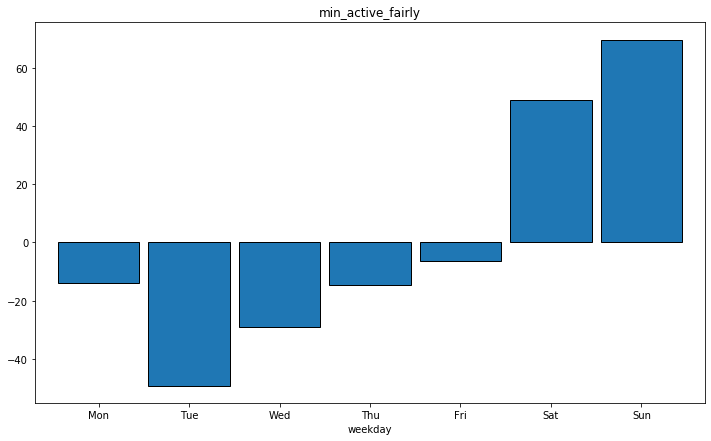

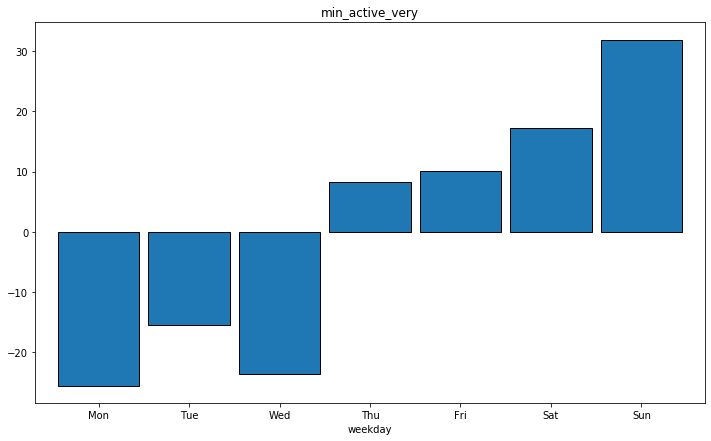

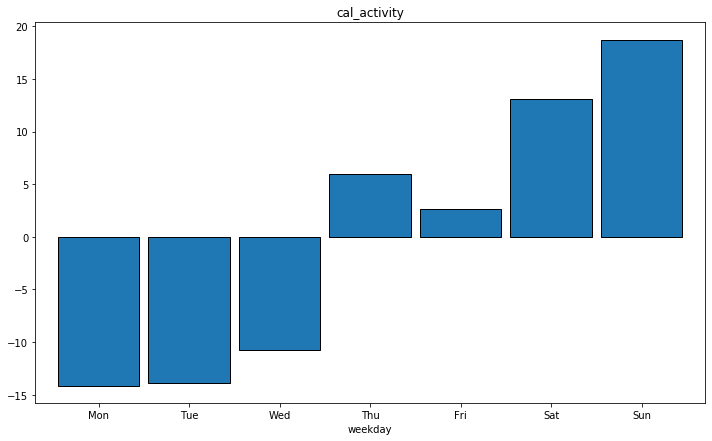

In [122]:
for var in target_vars:
    order = train.weekday.unique()
    #train.groupby('weekday')[var].mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    cal = pd.DataFrame()
    cal['ind'] = train.groupby('weekday')[var].mean().reindex(order) 
    cal['avg'] = train[var].mean()
    cal['pct_error'] = ((cal['ind']-cal['avg']) / cal['avg'])*100
    cal['pct_error'].plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    
    #train_weekday = train.groupby('weekday')[var].mean().reindex(order) 
    #train_weekday.plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.xticks(rotation=0)
    plt.title(var)
    plt.show()

In [70]:
train.index

DatetimeIndex(['2018-07-16', '2018-07-17', '2018-07-18', '2018-07-19',
               '2018-07-20', '2018-07-21', '2018-07-22', '2018-07-23',
               '2018-07-24', '2018-07-25',
               ...
               '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30',
               '2018-12-01', '2018-12-02', '2018-12-03', '2018-12-04',
               '2018-12-05', '2018-12-06'],
              dtype='datetime64[ns]', name='date', length=144, freq='D')

In [77]:
import calendar
import numpy as np
calendar.setfirstweekday(6)

def get_week_of_month(train):
    train = train.reset_index()
    wm = []
    for w in train.date:
        year = int(str(w).split('-')[0])
        month = int(str(w).split('-')[1])
        day = int(str(w).split('-')[2].split(' ')[0])
        x = np.array(calendar.monthcalendar(year, month))
        week_of_month = np.where(x==day)[0][0] + 1
        wm.append(week_of_month)
        #train['week_of_month'] = week_of_month
    return wm

In [78]:
wm = get_week_of_month(train)

In [80]:
train['week_of_day'] = wm

In [104]:
train[train.week_of_day == 6]

cal_burn  steps  distance  floors  min_sed  min_active_light  \
date                                                                       
2018-09-30      4184  15991      7.54       9      652               254   

            min_active_fairly  min_active_very  cal_activity weekday  \
date                                                                   
2018-09-30                 45               72          2504     Sun   

            week_of_day  
date                     
2018-09-30            6

**Takeaway** Visualizing by specific weeek of any month, did not see a strong trend in any particular features recorded with Fitbit.

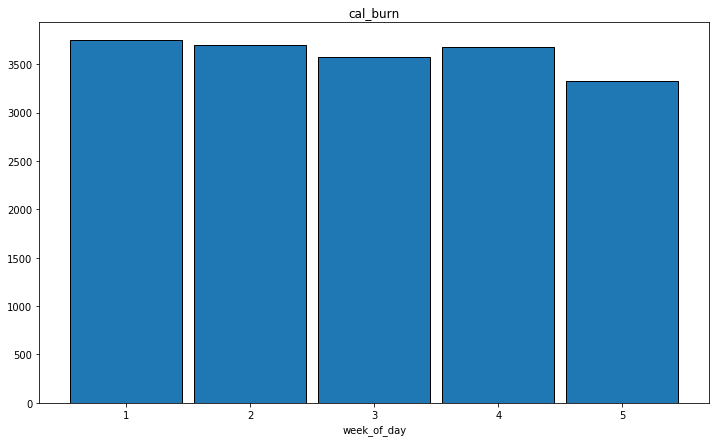

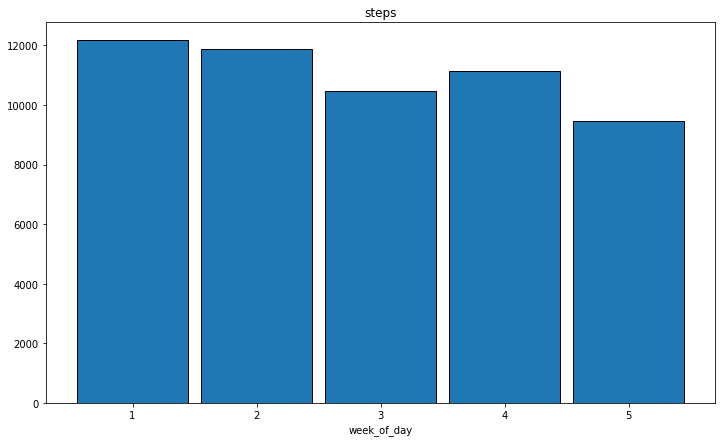

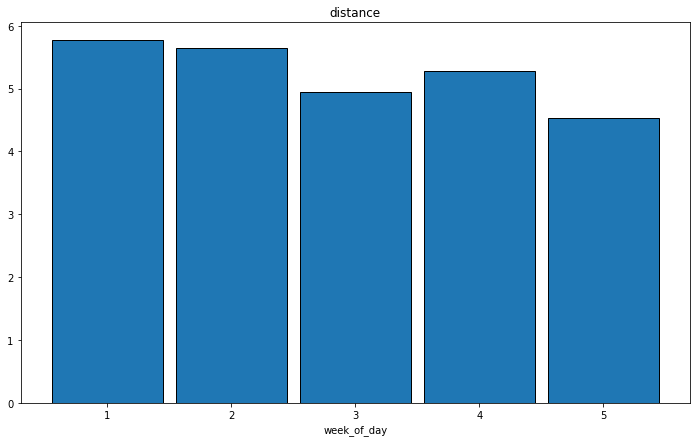

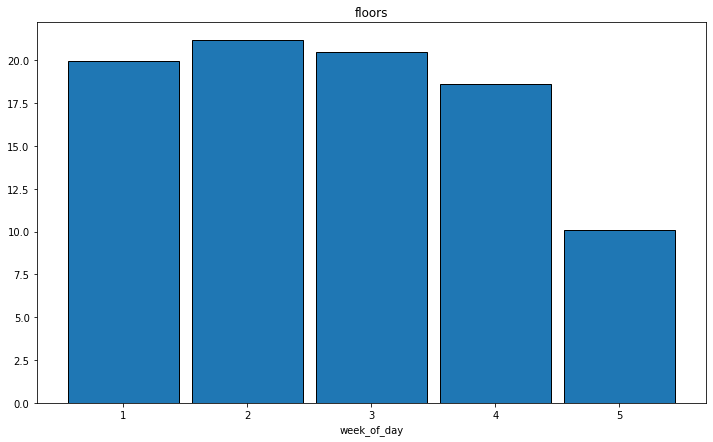

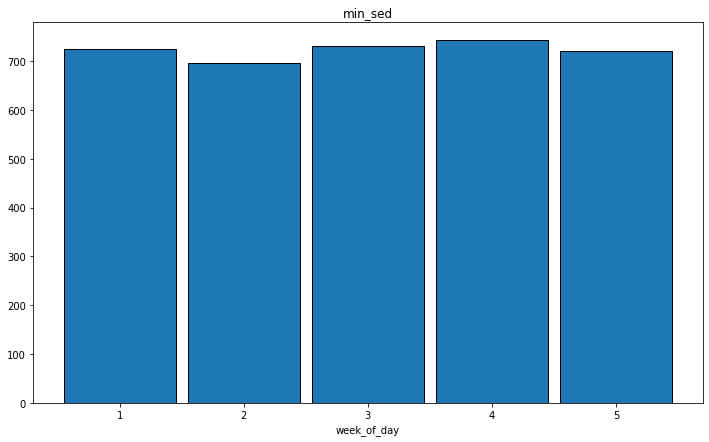

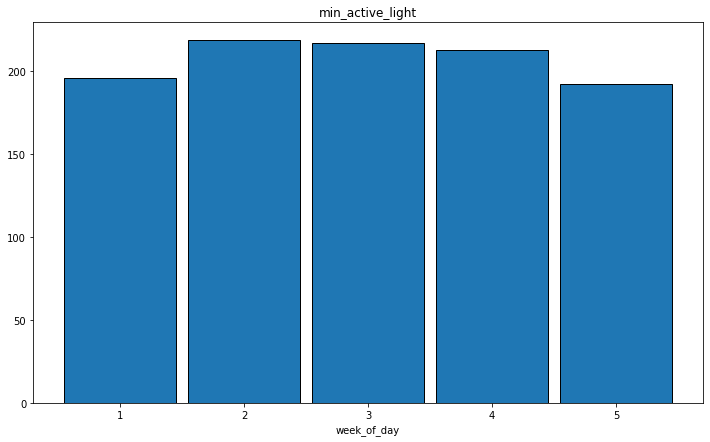

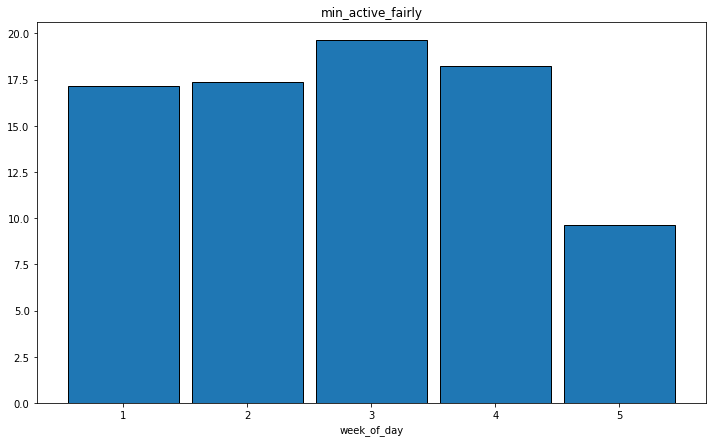

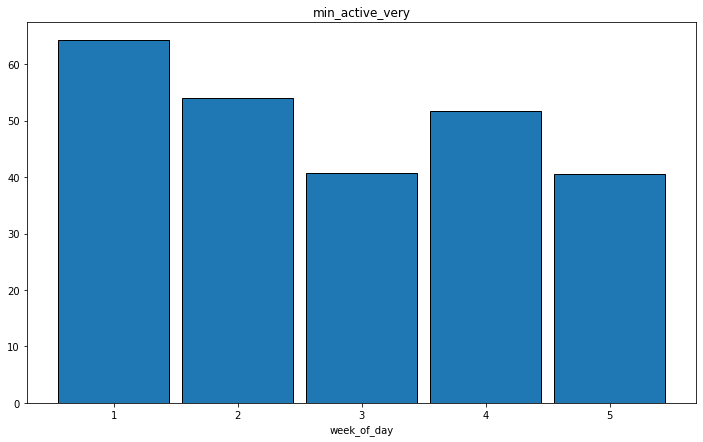

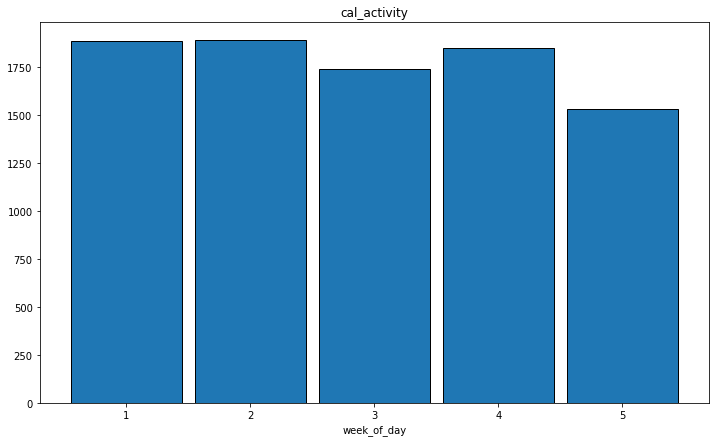

In [106]:
for var in target_vars:
    #order = ['1','2','3','4','5','6']
    #train.groupby('weekday')[var].mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    train_wk = train[train.week_of_day != 6].groupby('week_of_day')[var].mean()
    #train_wk = train#.reindex(order) 
    train_wk.plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.xticks(rotation=0)
    plt.title(var)
    plt.show()

In [ ]:
train['pct'] = train.groupby('weeks_of_yr')[var].mean()

In [113]:
(train.groupby('weeks_of_yr')[var].mean()).mean()

1783.6739229024943

**Takeawy** Weekly pattern

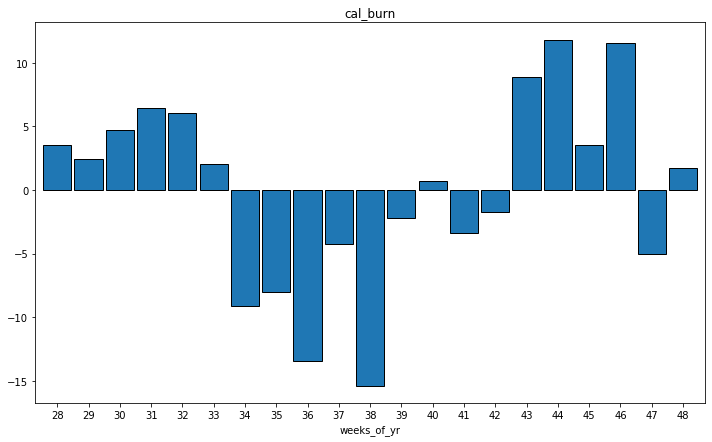

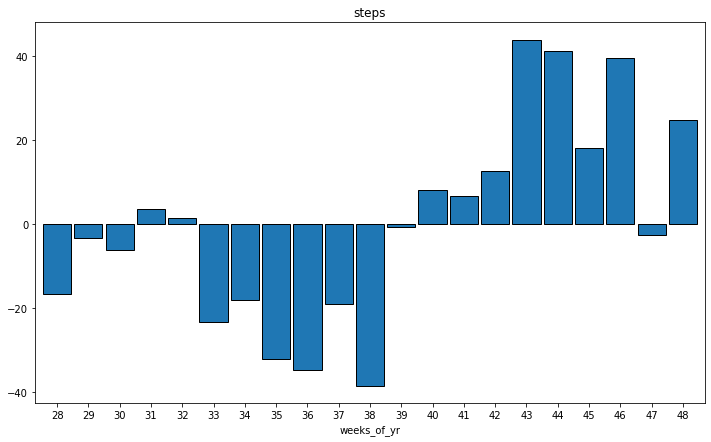

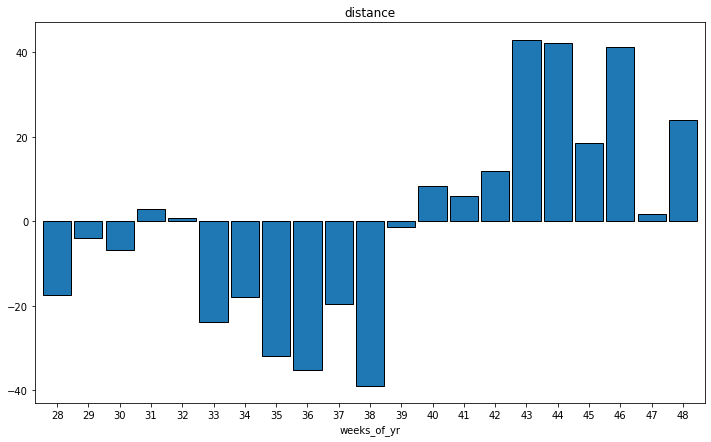

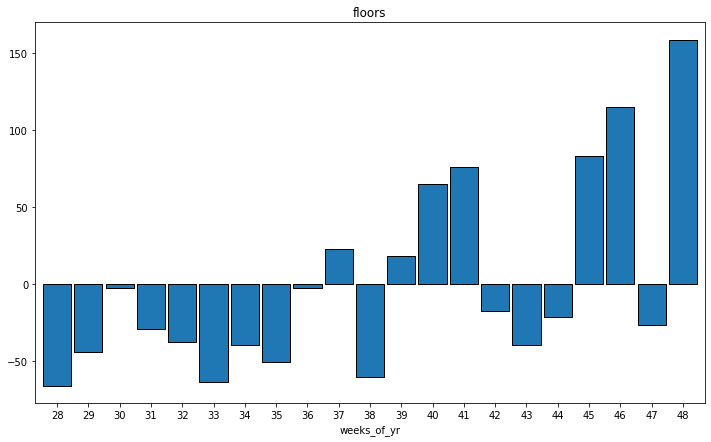

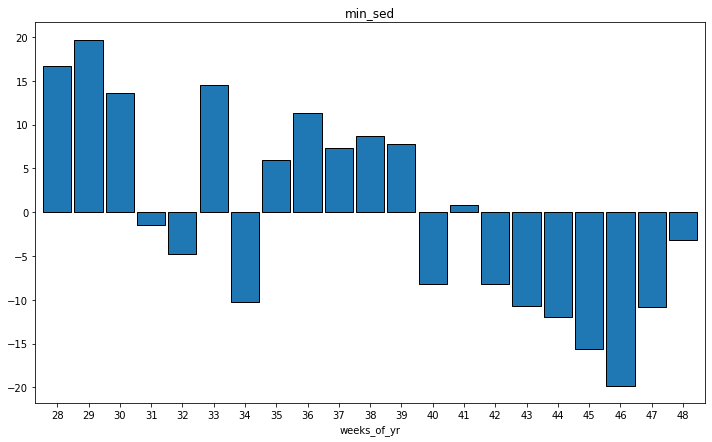

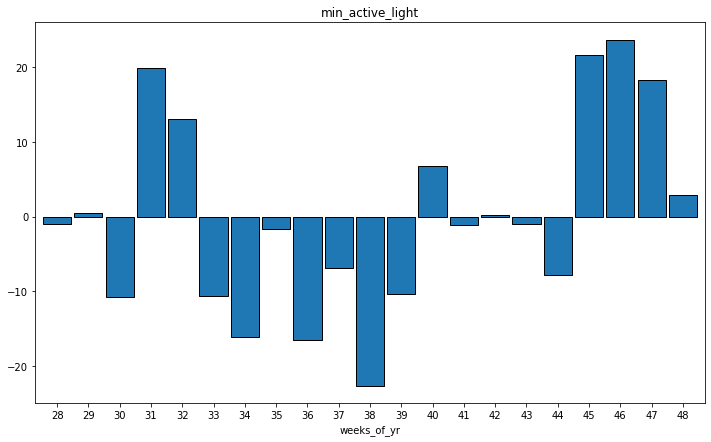

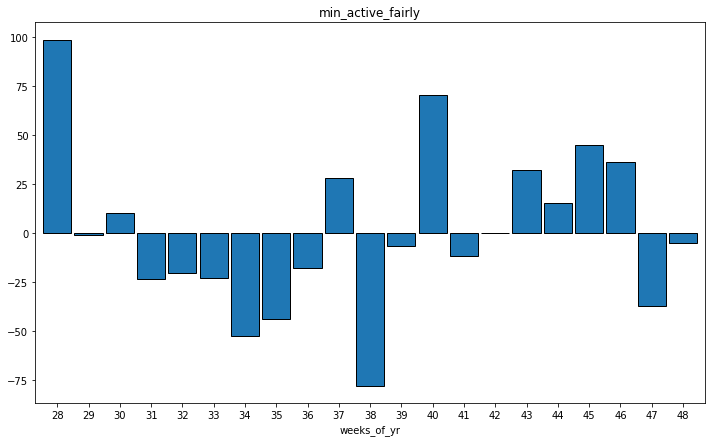

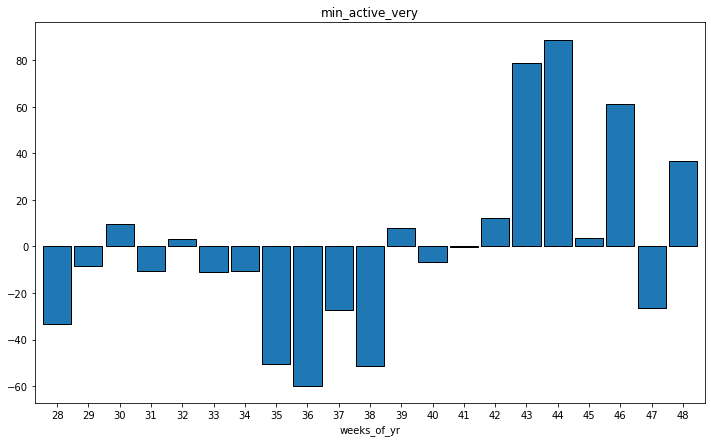

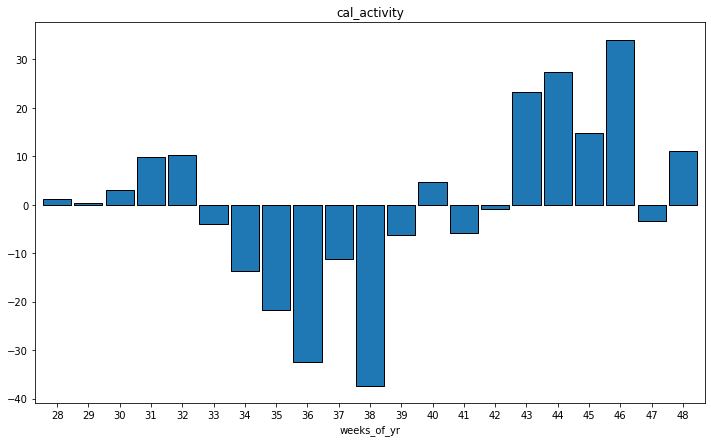

In [120]:
for var in target_vars:
    #order = train.weeks_of_yr'.unique()
    cal = pd.DataFrame()
    cal['ind'] = train.groupby('weeks_of_yr')[var].mean()
    cal['avg'] = train[var].mean()
    cal['pct_error'] = ((cal['ind']-cal['avg']) / cal['avg'])*100
    cal['pct_error'].plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    #train_weekday = train.groupby('weekday')[var].mean().reindex(order) 
    #train_weekday.plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.xticks(rotation=0)
    plt.title(var)
    plt.show()

In [110]:
train.columns

Index(['cal_burn', 'steps', 'distance', 'floors', 'min_sed',
       'min_active_light', 'min_active_fairly', 'min_active_very',
       'cal_activity', 'weekday', 'week_of_day', 'weeks_of_yr', 'months'],
      dtype='object')

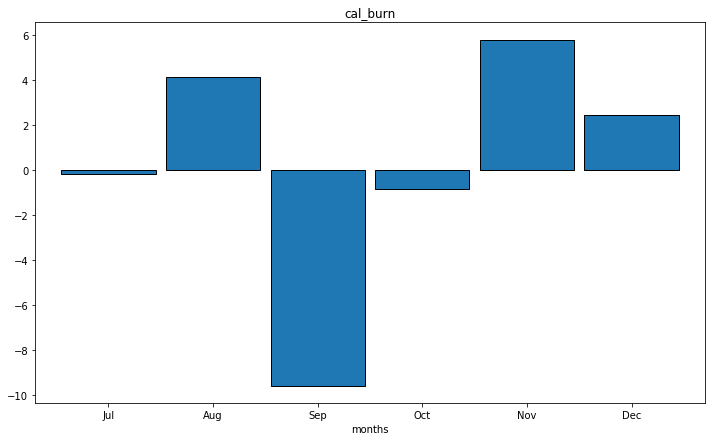

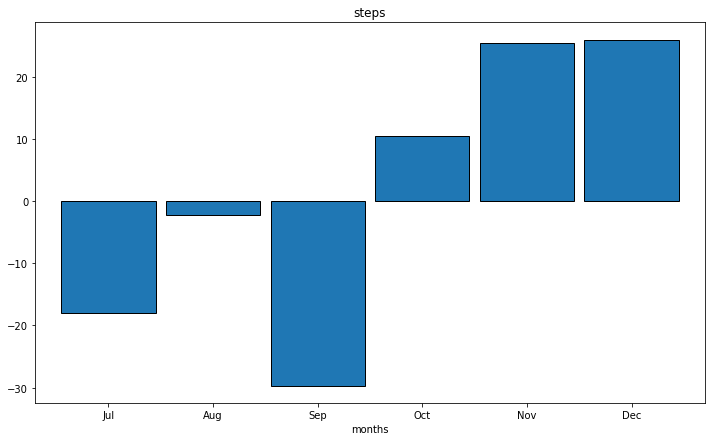

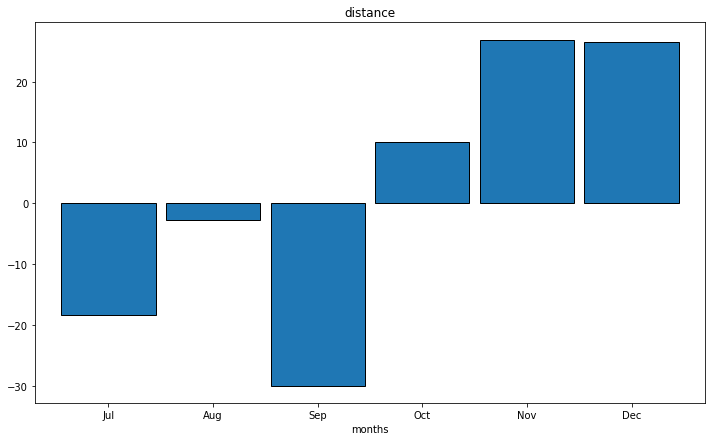

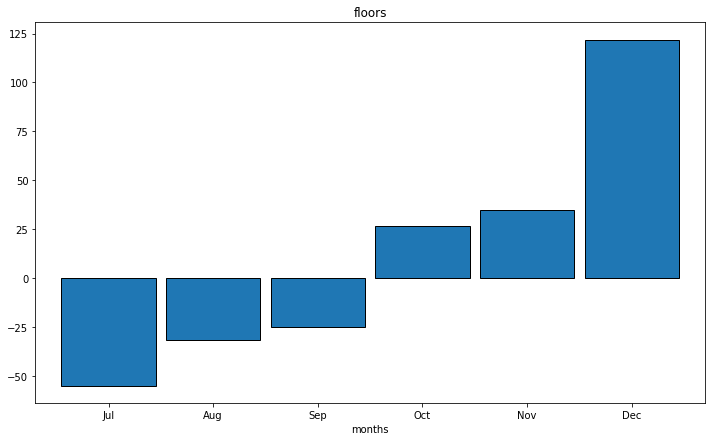

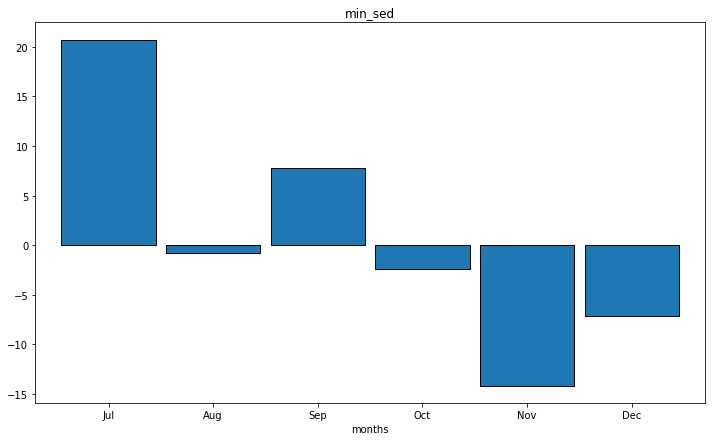

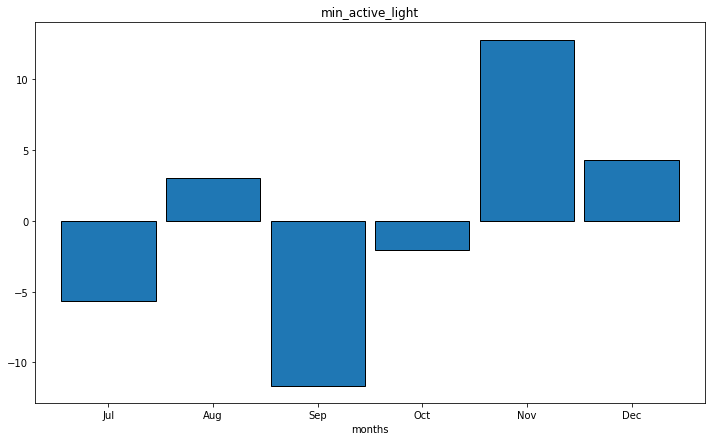

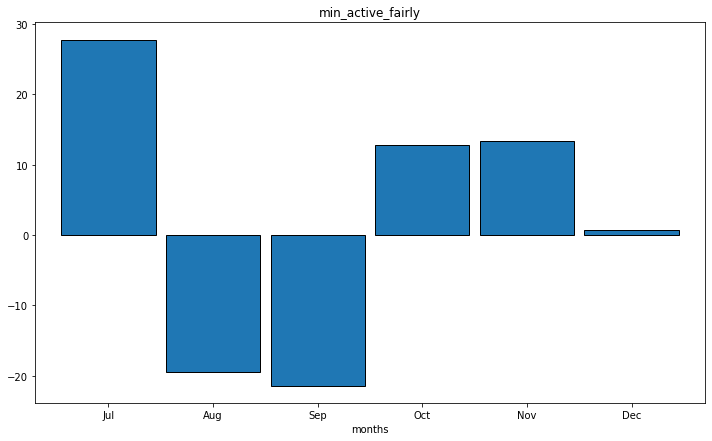

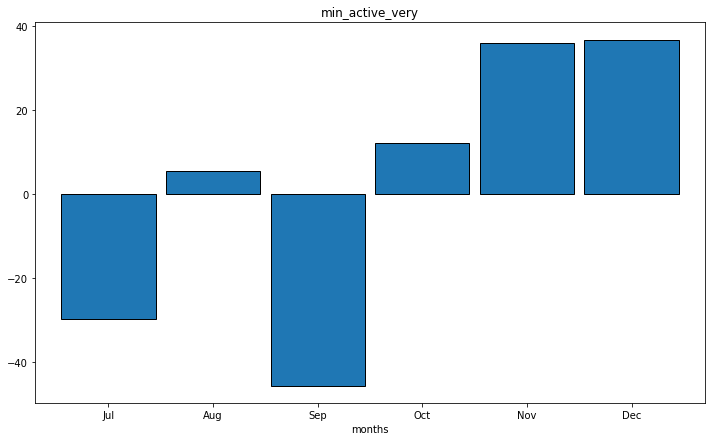

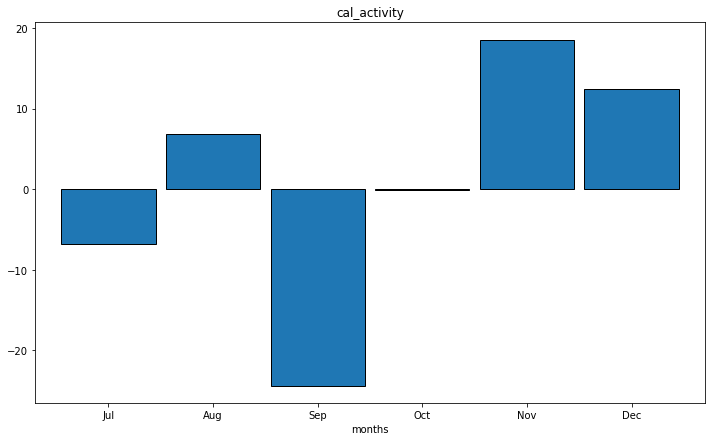

In [121]:
for var in target_vars:
    order = train.months.unique()
    cal = pd.DataFrame()
    cal['ind'] = train.groupby('months')[var].mean().reindex(order) 
    cal['avg'] = train[var].mean()
    cal['pct_error'] = ((cal['ind']-cal['avg']) / cal['avg'])*100
    cal['pct_error'].plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    #train.groupby('weeks_of_yr')[var].mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    #train_weekday = train.groupby('months')[var].mean().reindex(order) 
    #train_weekday.plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.xticks(rotation=0)
    plt.title(var)
    plt.show()

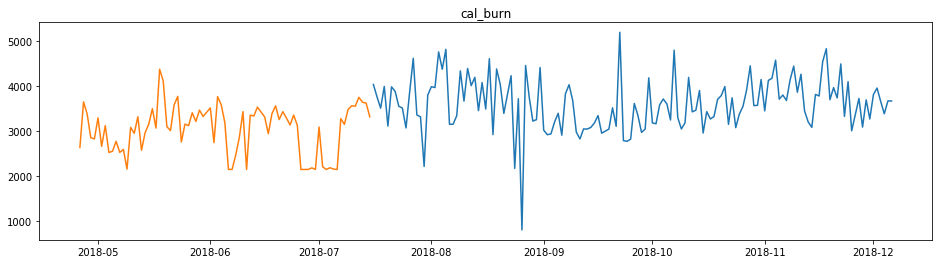

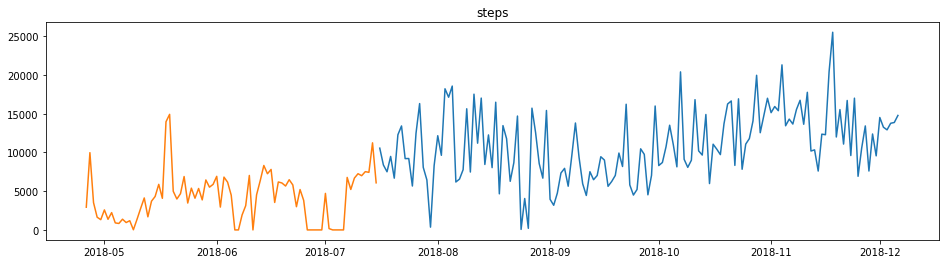

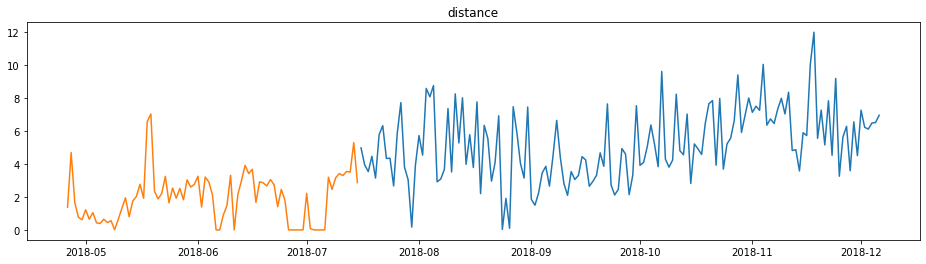

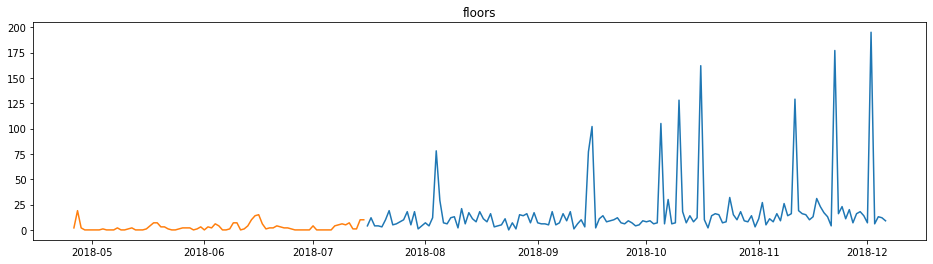

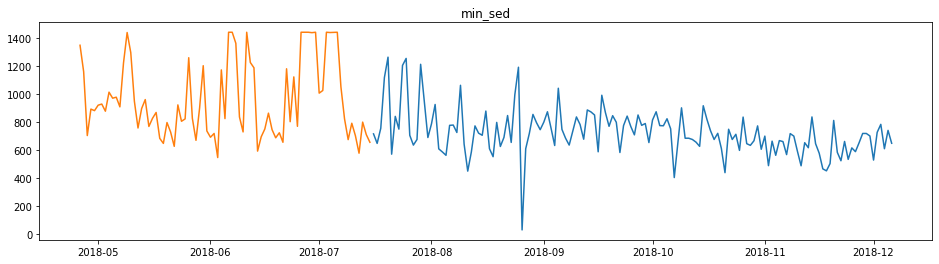

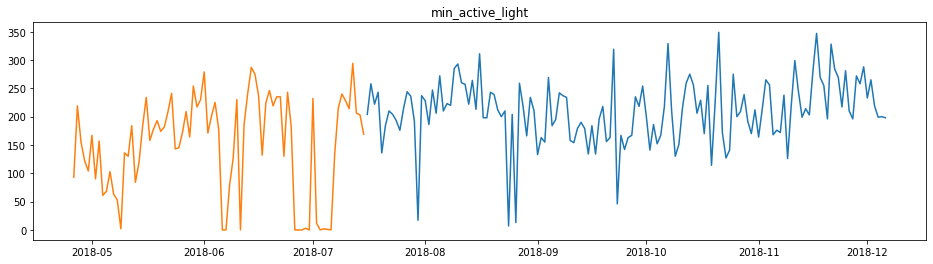

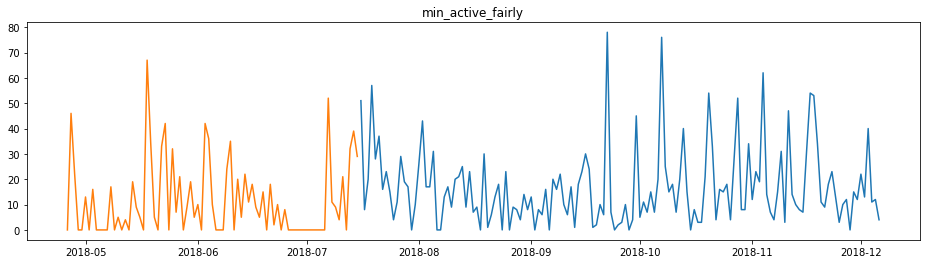

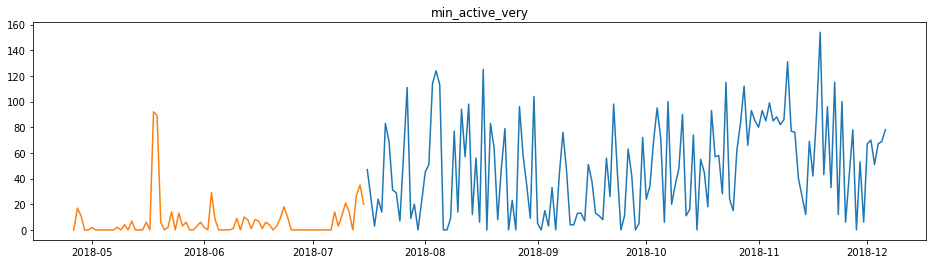

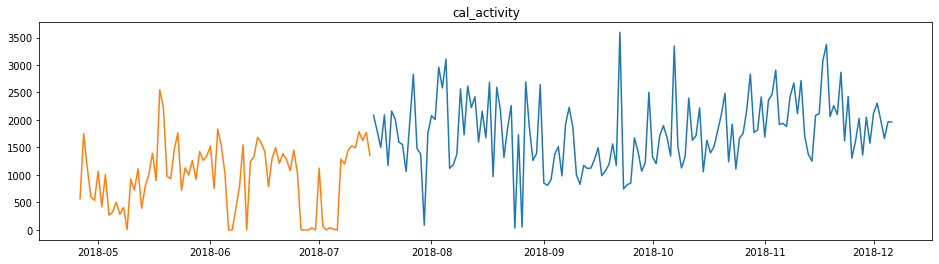

In [9]:
for var in target_vars:
    plt.figure(figsize=(16, 4))
    plt.plot(train[var])
    plt.plot(test[var])    
    plt.title(var)
    plt.show()

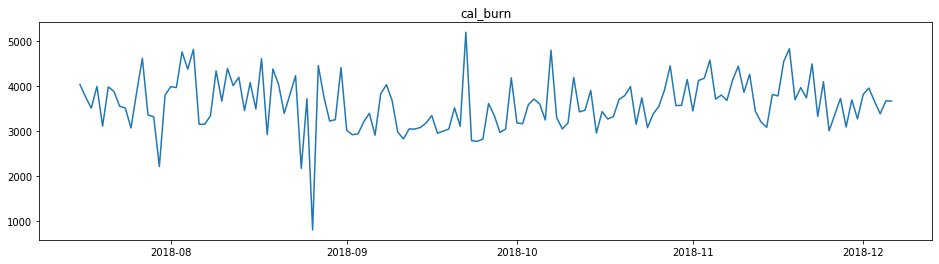

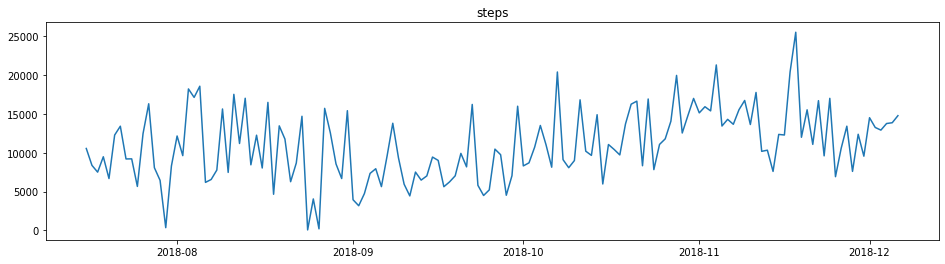

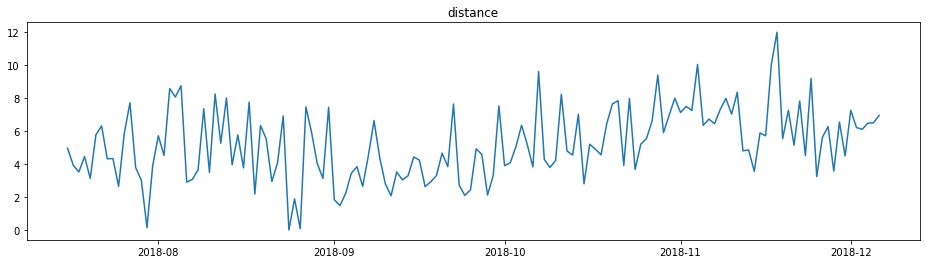

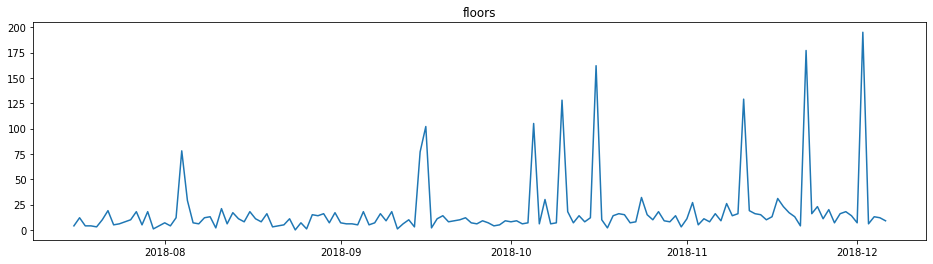

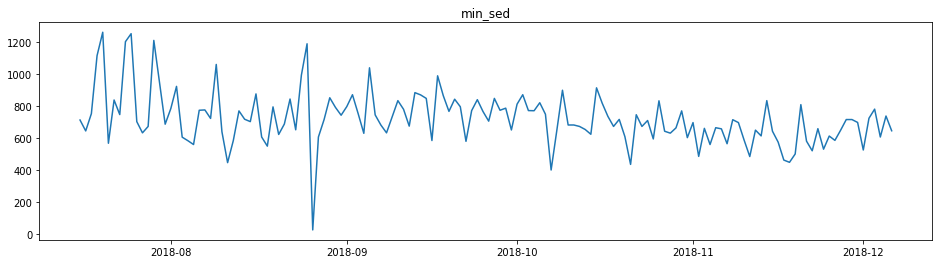

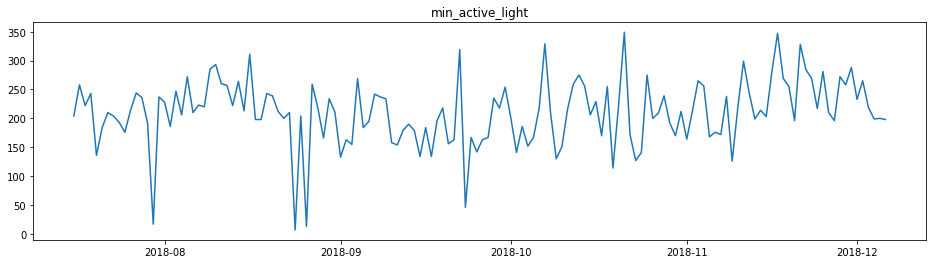

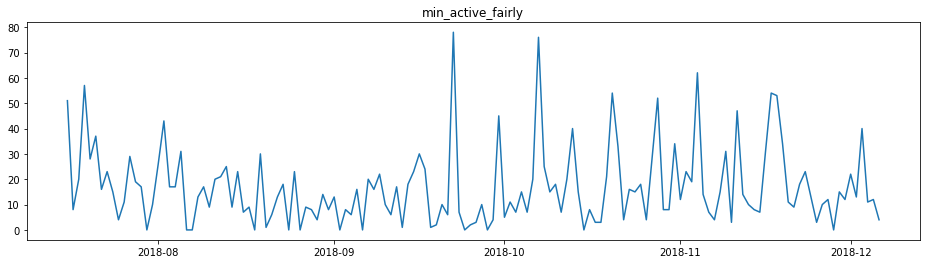

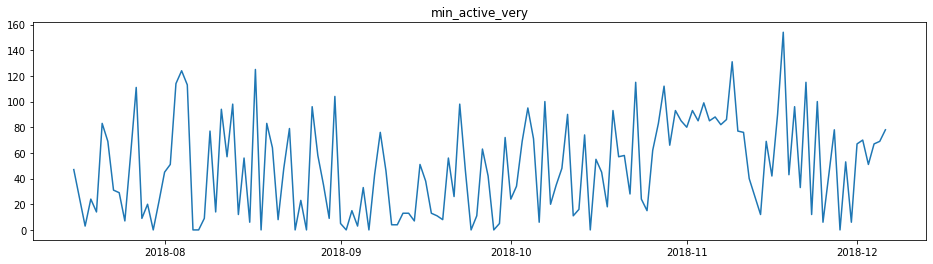

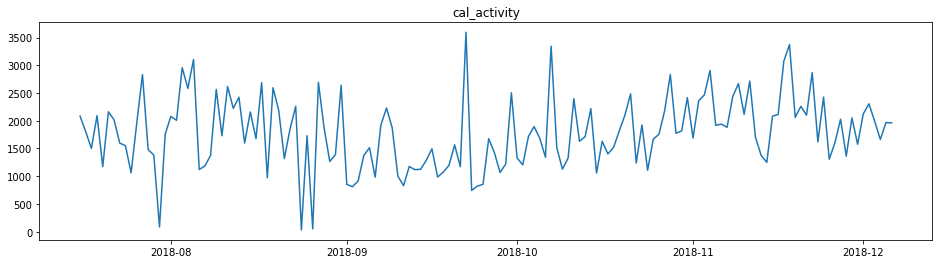

In [10]:
for var in target_vars:
    plt.figure(figsize=(16, 4))
    plt.plot(train[var])
    #plt.plot(test[var])    
    plt.title(var)
    plt.show()

In [11]:
train = train.resample('W')[target_vars].sum()

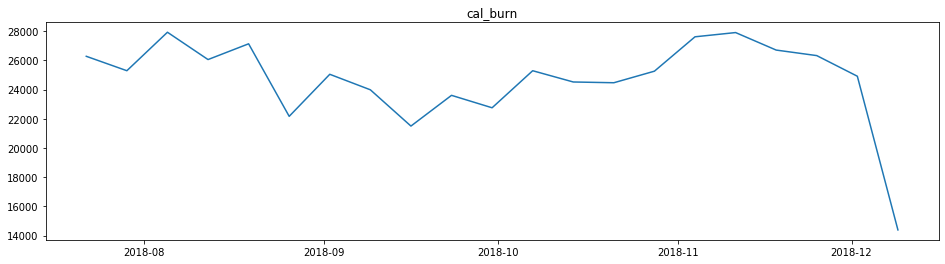

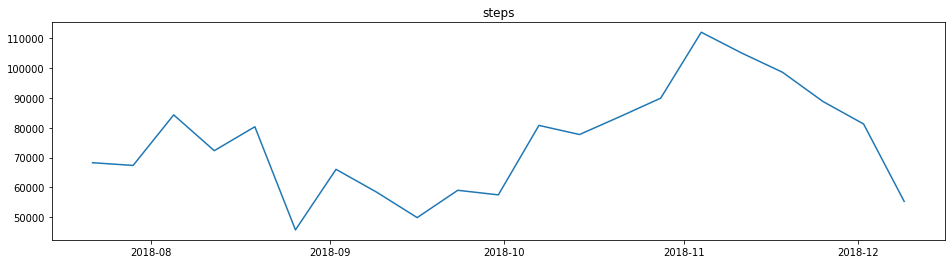

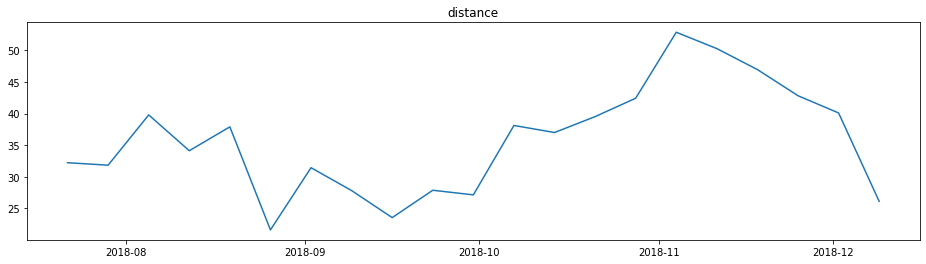

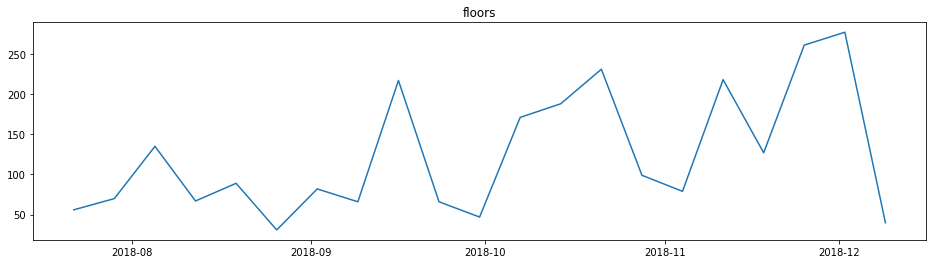

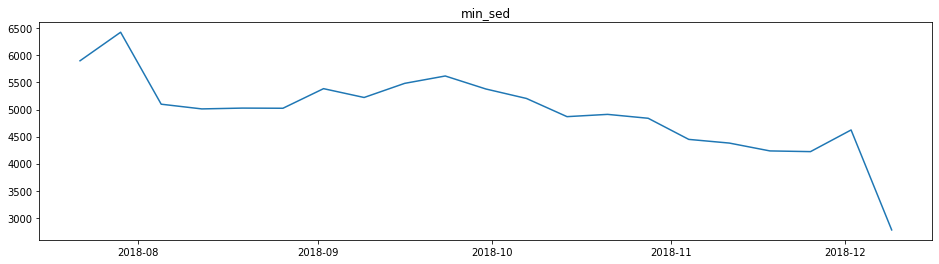

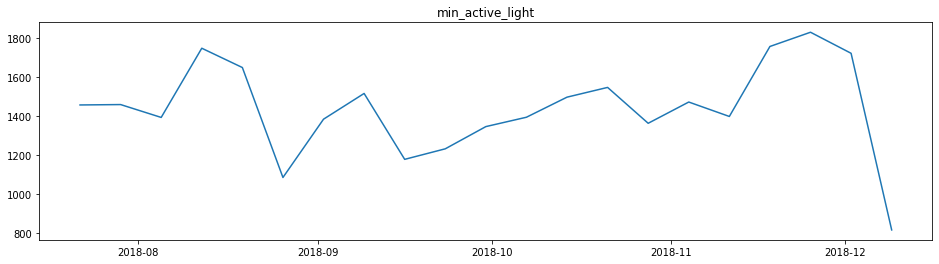

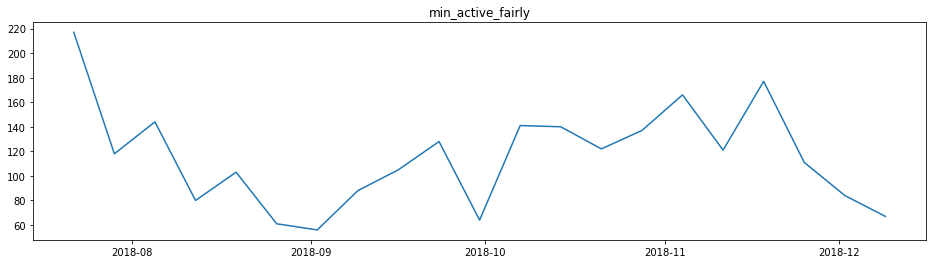

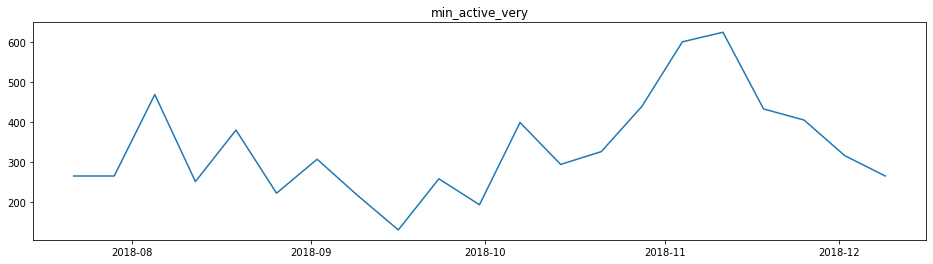

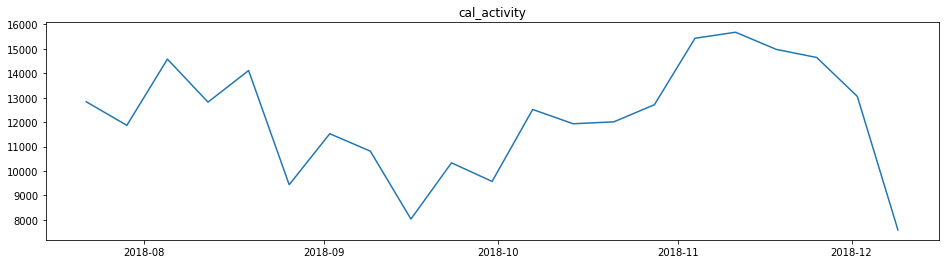

In [12]:
for var in target_vars:
    plt.figure(figsize=(16, 4))
    plt.plot(train[var])
    #plt.plot(test[var])    
    plt.title(var)
    plt.show()

In [13]:
train = train.resample('M')[target_vars].sum()

In [14]:
train

cal_burn   steps  distance  floors  min_sed  min_active_light  \
date                                                                        
2018-07-31     51563  135673     64.03     126    12327              2916   
2018-08-31    103269  282776    133.35     322    20158              5875   
2018-09-30    116870  290902    137.71     478    27088              6656   
2018-10-31     99523  332301    157.03     689    19820              5801   
2018-11-30    108537  404650    192.93     685    17285              6457   
2018-12-31     39293  136608     66.18     317     7398              2538   

            min_active_fairly  min_active_very  cal_activity  
date                                                          
2018-07-31                335              530         24698  
2018-08-31                388             1322         50941  
2018-09-30                441             1104         50267  
2018-10-31                540             1458         49168  
2018-11-30                575             2064         60731  
2018-12-31                151              581         20636

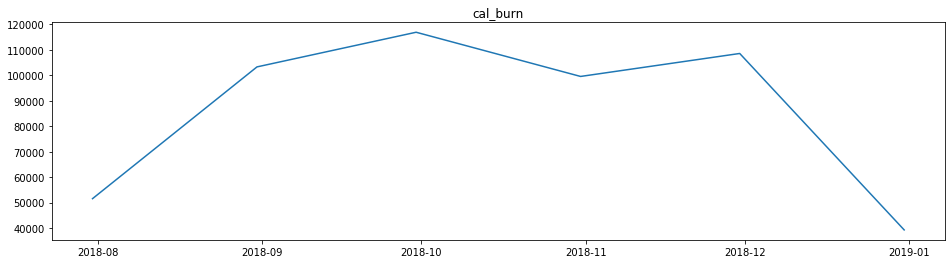

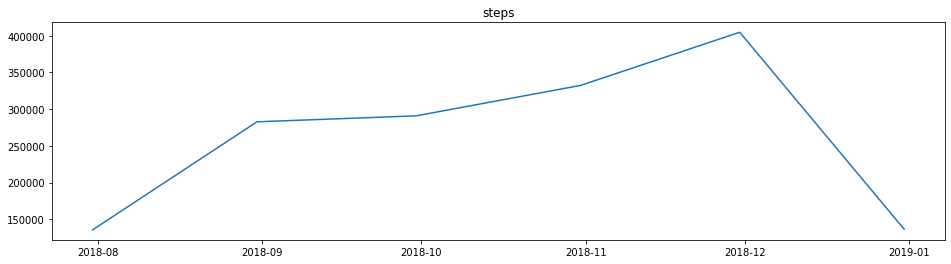

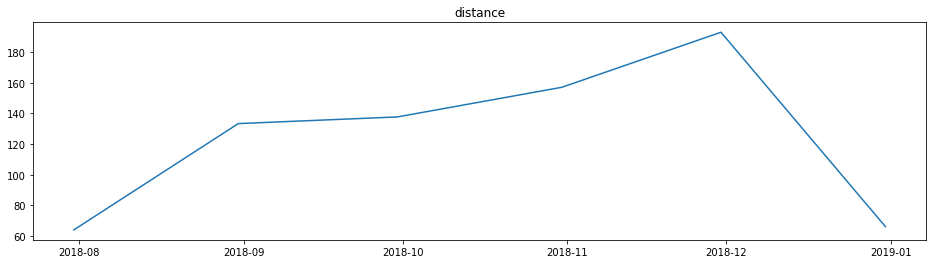

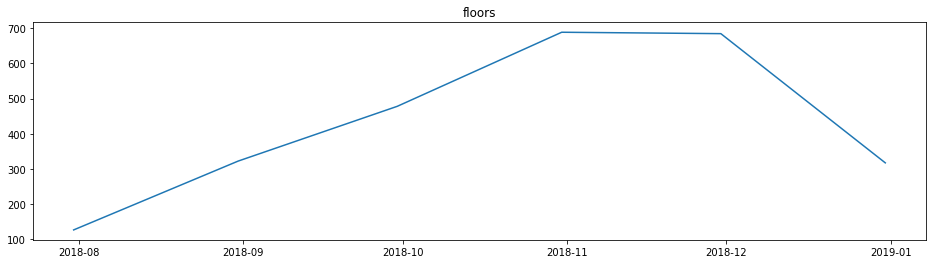

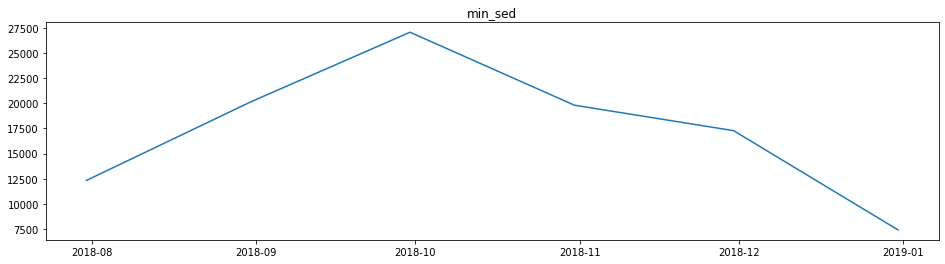

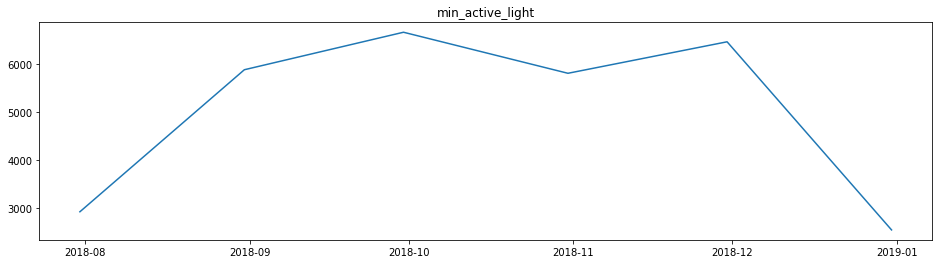

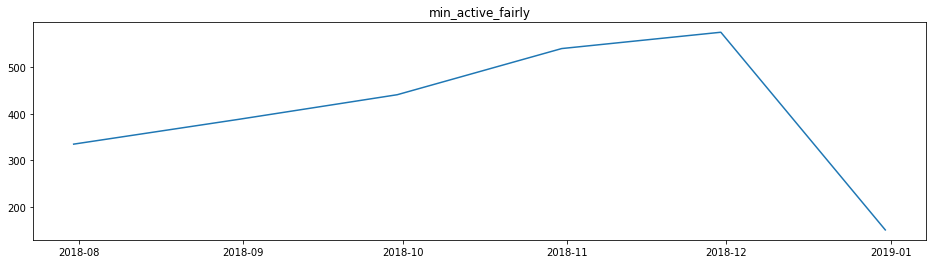

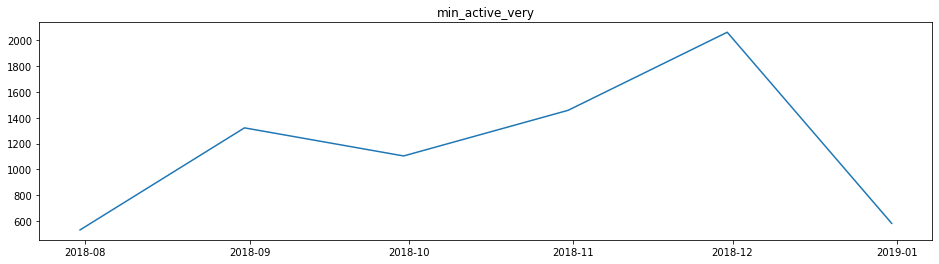

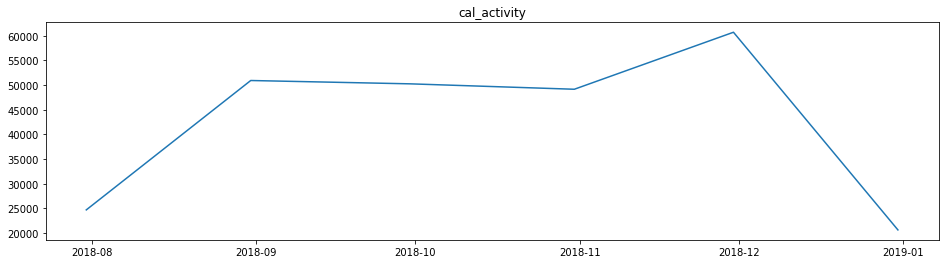

In [15]:
for var in target_vars:
    plt.figure(figsize=(16, 4))
    plt.plot(train[var])
    #plt.plot(test[var])    
    plt.title(var)
    plt.show()

1. Are there any day of the week where Armstrong is particularly more active or sedentary?

2. Do Armstrong have weekly patterns of activity?
3. During which months is Armstrong more/less active?

D
cal_burn


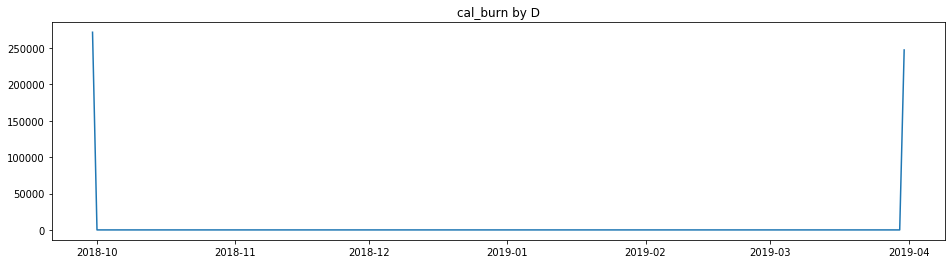

W
cal_burn


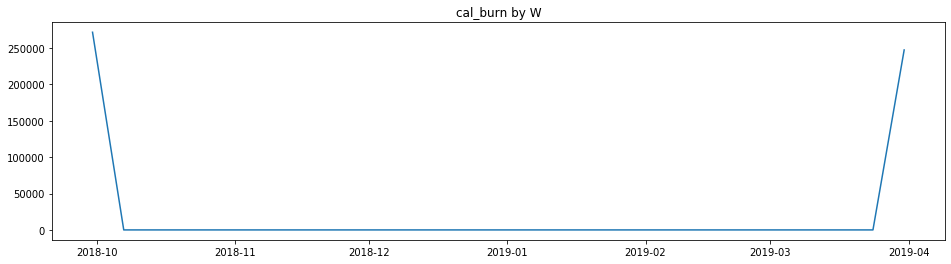

M
cal_burn


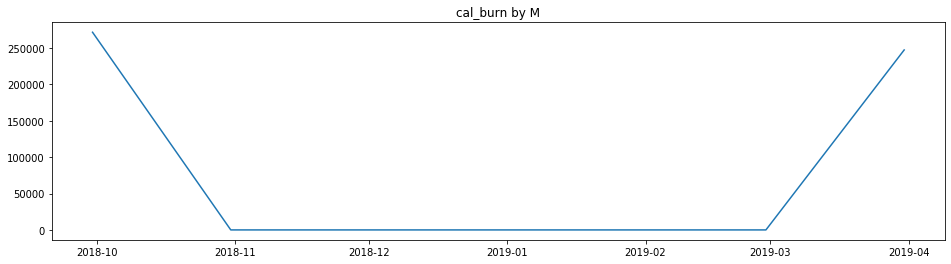

D
steps


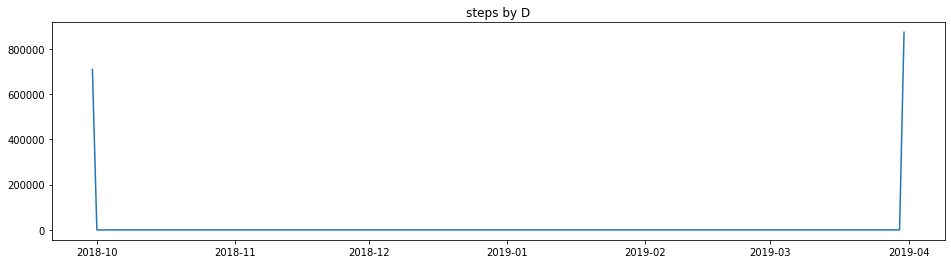

W
steps


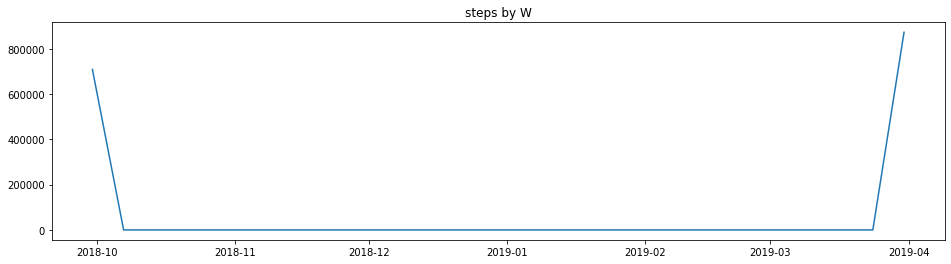

M
steps


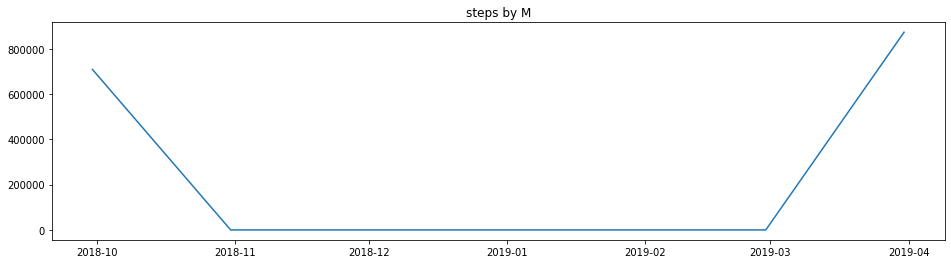

D
distance


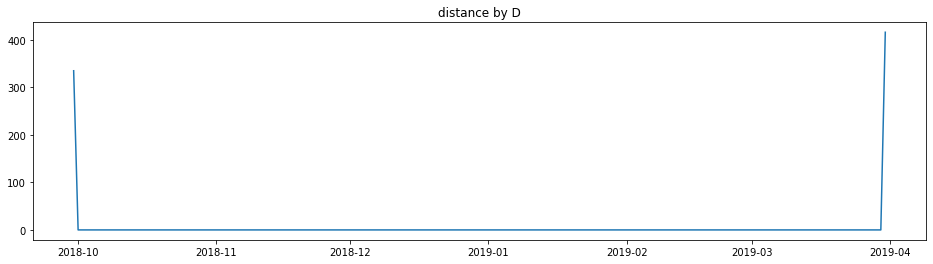

W
distance


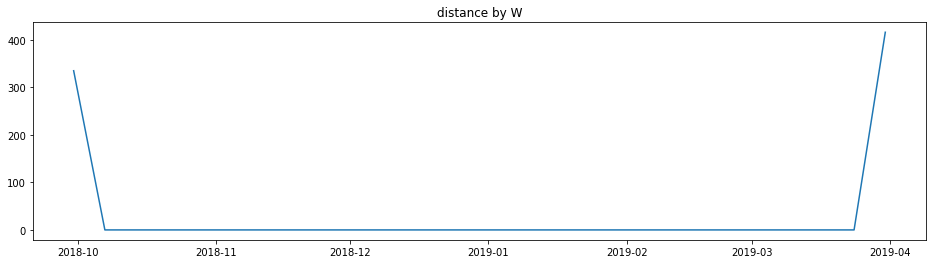

M
distance


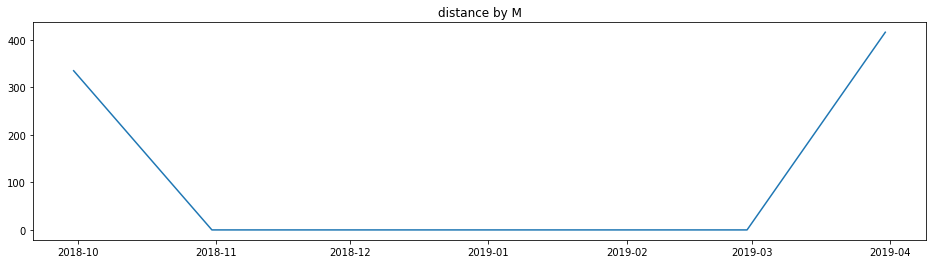

D
floors


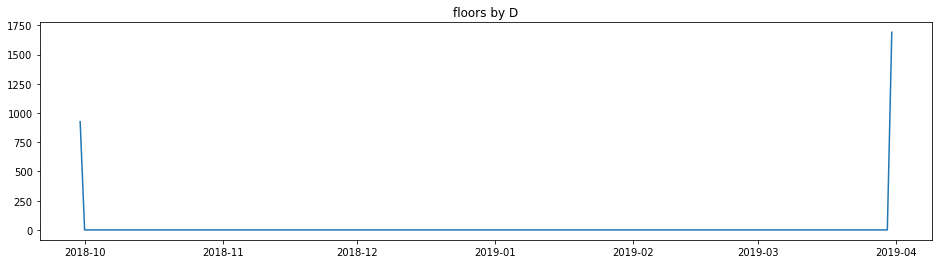

W
floors


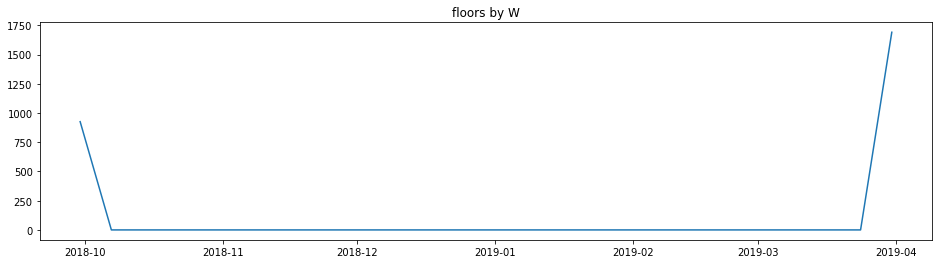

M
floors


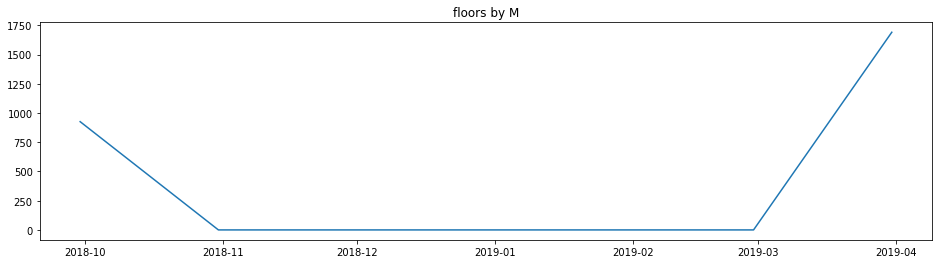

D
min_sed


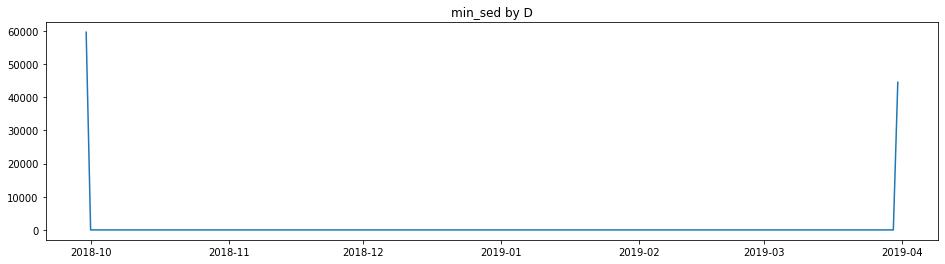

W
min_sed


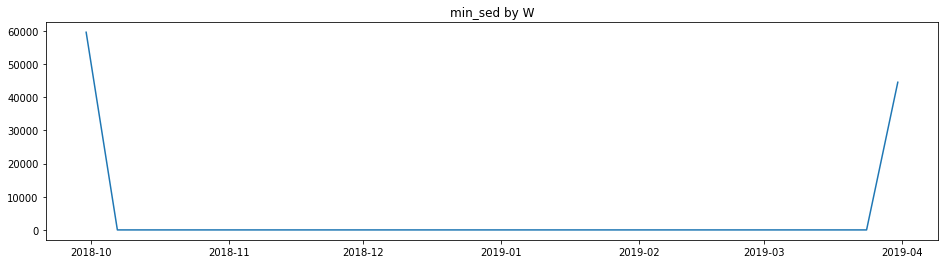

M
min_sed


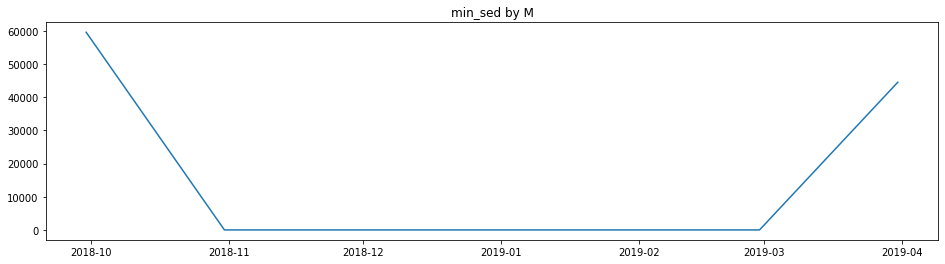

D
min_active_light


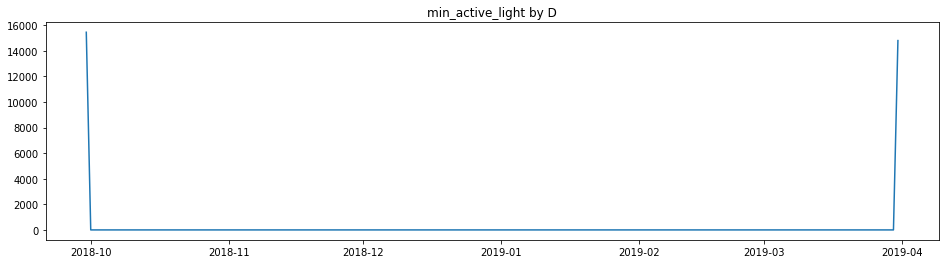

W
min_active_light


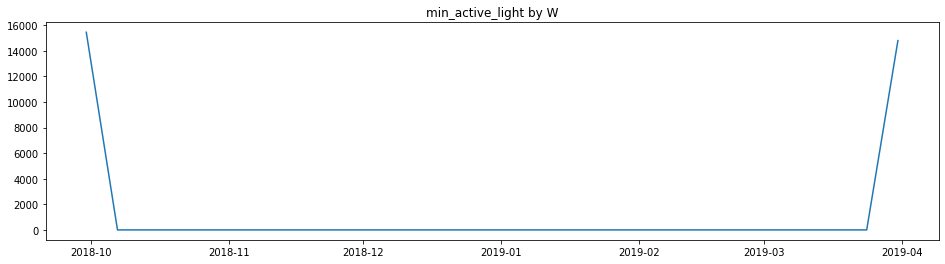

M
min_active_light


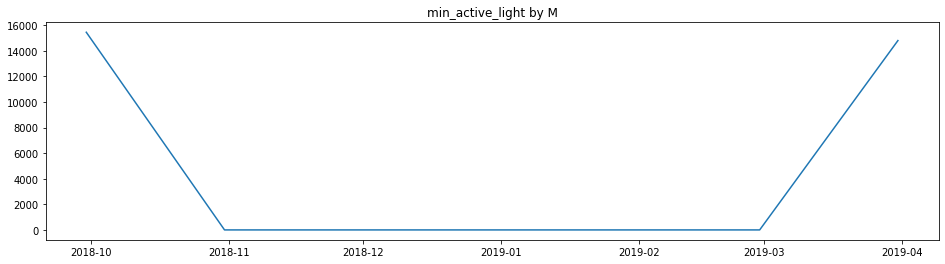

D
min_active_fairly


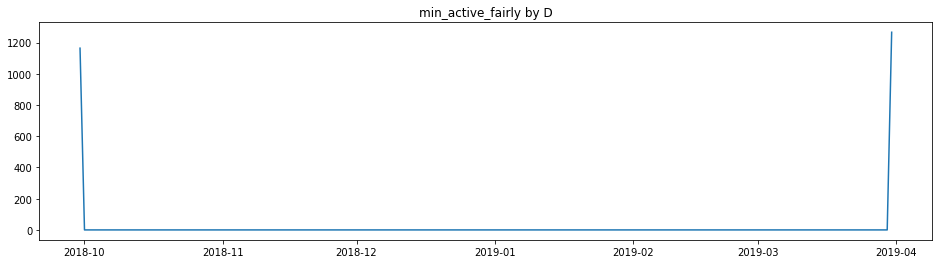

W
min_active_fairly


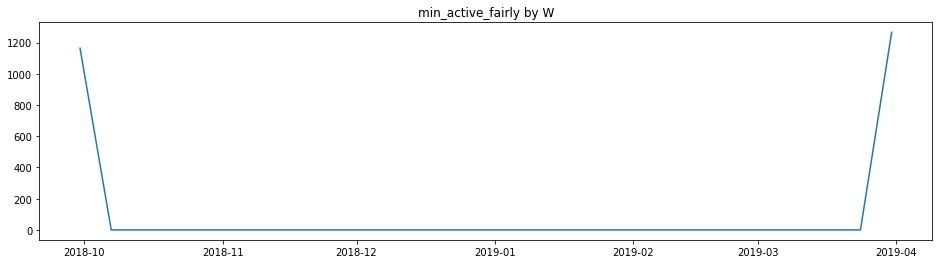

M
min_active_fairly


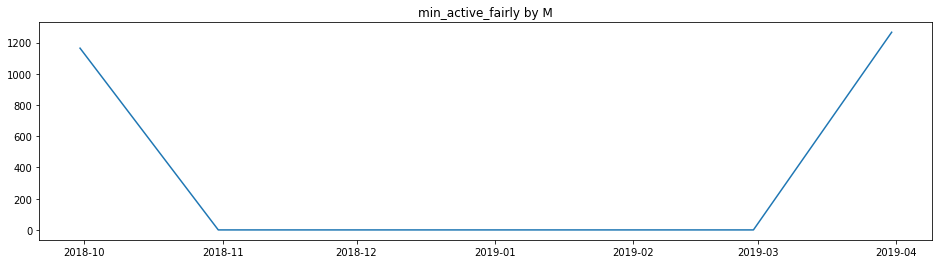

D
min_active_very


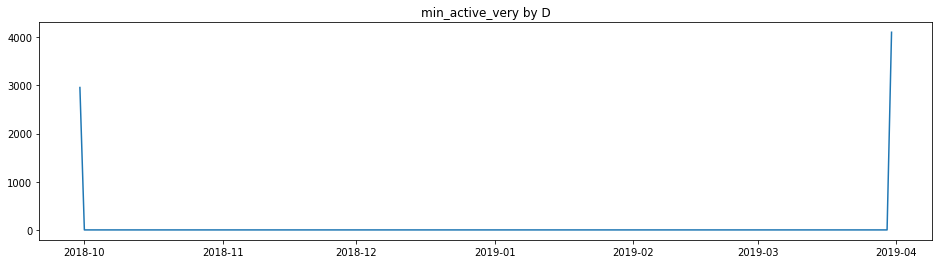

W
min_active_very


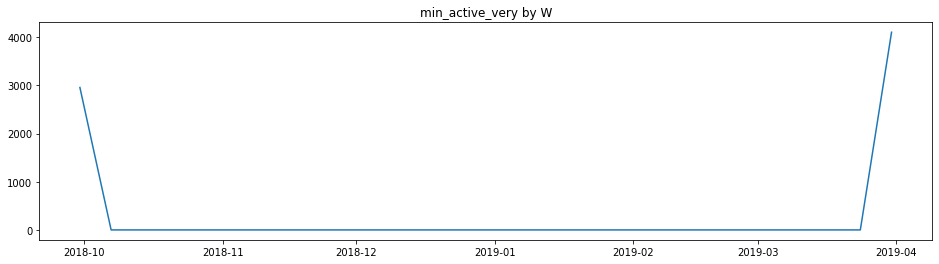

M
min_active_very


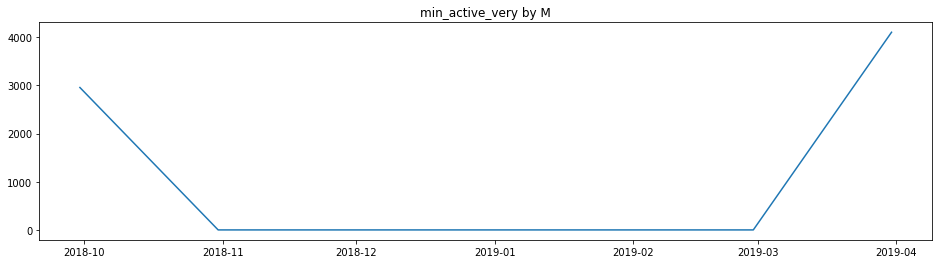

D
cal_activity


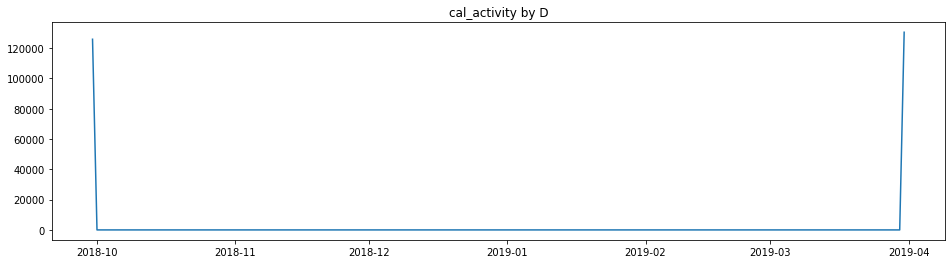

W
cal_activity


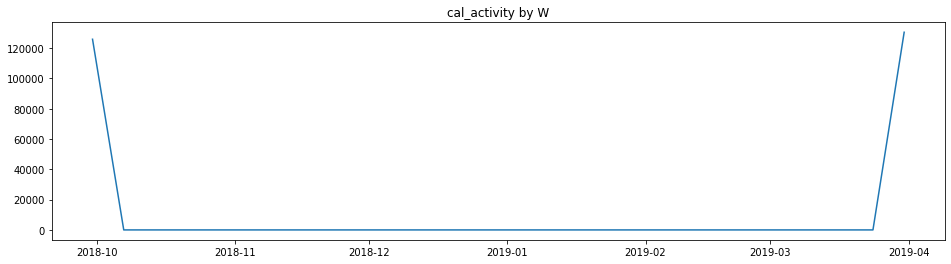

M
cal_activity


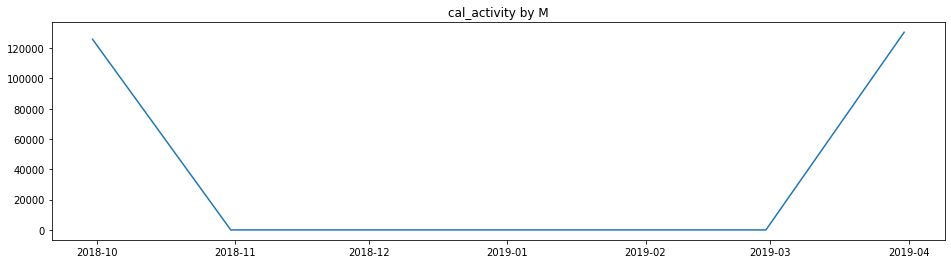

In [10]:
for var in target_vars:
    freqs = ['D','W','M']
#    freqs = {"D": "Daily", "W": "Weekly", "M": "Monthly", "A": "Annually"}
    for freq in freqs:
        print(freq)
        print(var)
        train = train.resample(freq)[target_vars].sum()
#         test = test.resample(freq)[target_vars].sum().reset_index()
        plt.figure(figsize=(16, 4))
        plt.plot(train[var])
#         plt.plot(test[var])    
        plt.title(var + ' by ' + freq)
        plt.show()

In [ ]:
# explore

In [ ]:
def prep_data(df: pd.DataFrame) -> pd.DataFrame:
    return (df.assign(ds=pd.to_datetime(df.Month_Invoiced)).sort_values('ds')
            .assign(y=df.Amount)\
            .groupby(['ds'])['y'].sum().reset_index().set_index('ds'))

In [ ]:
df = prep_data(df)

In [ ]:
def split_store_data(df, train_prop): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size].reset_index(), df[train_size:len(df)].reset_index()
    return train, test

In [ ]:
train, test = split_store_data(df2, train_prop=.80)

print('Observations: %d' % (len(df2)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

In [ ]:
train = train.set_index('ds')
test = test.set_index('ds')

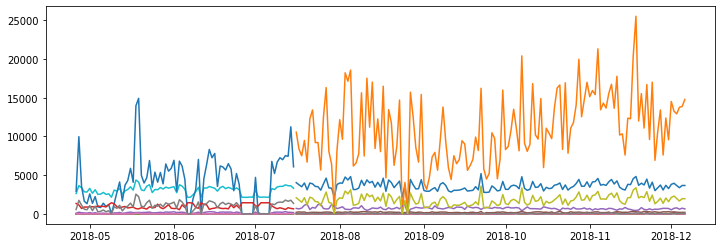

In [12]:
# peek data
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(test)

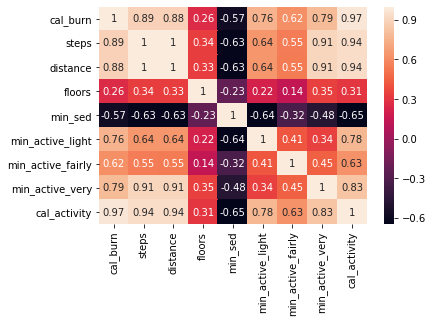

In [14]:
sns.heatmap(df.corr(), annot = True)

# Model

In [ ]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [ ]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

In [ ]:
# create df to store MSE & RMSE
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [ ]:
periods = 30
yhat['y'] = train.y.rolling(periods).mean().iloc[-1]

# plot_and_eval(target_vars, train, test)
# eval_df = append_eval_df(model_type='moving_average', target_vars=['y'], train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = [1, 4, 12, 26, 52, 104]
for p in period_vals:
    yhat['y'] = train.y.rolling(p).mean().iloc[-1]
    plt.plot(yhat.y)
    print('\nrolling averge period:',p)
    print('\nitem sales\n')
    evaluate('y', train = train, test = test)